In [ ]:
%reload_ext autoreload
%autoreload 2

Prep

In [ ]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_rows', 200)

from tqdm import tqdm
import getpass
import logging

logging.basicConfig(level=logging.ERROR)

In [ ]:
from adapter_covid19.data_structures import Scenario, ModelParams
from adapter_covid19.simulator import Simulator

Initialize simulator

In [ ]:
data_path = f"/home/{getpass.getuser()}/adaptER-covid19/tests/adapter_covid19/data"

simulator = Simulator(data_path)

Inialize scenarios

Run spread model once

In [26]:
import example_utils as utils
population = 10000
params = utils.get_baseline_parameters()
params.set_param( "n_total", population )

sim = utils.get_simulation( params )
sim.steps( 200 )

timeseries = pd.DataFrame( sim.results )
ill_ratio = timeseries["n_symptoms"]  / population
dead_ratio = timeseries["n_death"] / population

In [27]:
timeseries.columns

Index(['time', 'lockdown', 'test_on_symptoms', 'app_turned_on',
       'total_infected', 'total_infected_0_9', 'total_infected_10_19',
       'total_infected_20_29', 'total_infected_30_39', 'total_infected_40_49',
       'total_infected_50_59', 'total_infected_60_69', 'total_infected_70_79',
       'total_infected_80', 'total_case', 'total_case_0_9', 'total_case_10_19',
       'total_case_20_29', 'total_case_30_39', 'total_case_40_49',
       'total_case_50_59', 'total_case_60_69', 'total_case_70_79',
       'total_case_80', 'total_death', 'total_death_0_9', 'total_death_10_19',
       'total_death_20_29', 'total_death_30_39', 'total_death_40_49',
       'total_death_50_59', 'total_death_60_69', 'total_death_70_79',
       'total_death_80', 'n_presymptom', 'n_asymptom', 'n_quarantine',
       'n_tests', 'n_symptoms', 'n_hospital', 'n_critical', 'n_death',
       'n_recovered'],
      dtype='object')

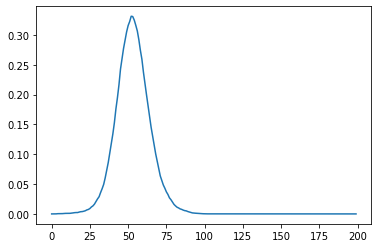

In [28]:
ill_ratio.plot()

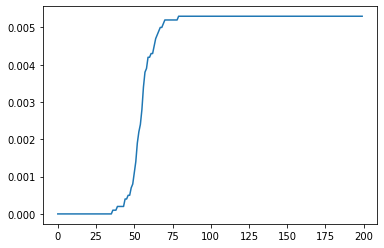

In [7]:
dead_ratio.plot()

In [8]:
from adapter_covid19.scenarios import BASIC_SCENARIO

In [9]:
scenarios = { 
    '10 days only': Scenario(
        lockdown_recovery_time=1,
        lockdown_start_time=5,
        lockdown_end_time=30,
        furlough_start_time=5,
        furlough_end_time=30,
        simulation_end_time=10,
        new_spending_day=5,
        ccff_day=5,
        loan_guarantee_day=5,
        model_params= ModelParams(
            economics_params={},
            gdp_params={},
            personal_params={
                'default_th':300,
                'max_earning_furloughed':30_000,
                'alpha':5,
                'beta':20,
            },
            corporate_params={
                'beta':1.4,
                'large_cap_cash_surplus_months':6,
            },
        ),
        ill_ratio=ill_ratio,
        dead_ratio=dead_ratio,
    ),
#     '109 days': Scenario(
#         lockdown_recovery_time=1,
#         lockdown_start_time=5,
#         lockdown_end_time=30,
#         furlough_start_time=5,
#         furlough_end_time=30,
#         simulation_end_time=109,
#         new_spending_day=5,
#         ccff_day=5,
#         loan_guarantee_day=5,
#         model_params= ModelParams(
#             economics_params={},
#             gdp_params={},
#             personal_params={
#                 'default_th':300,
#                 'max_earning_furloughed':30_000,
#                 'alpha':5,
#                 'beta':20,
#             },
#             corporate_params={
#                 'beta':1.4,
#                 'large_cap_cash_surplus_months':6,
#             },
#         ),
#     ),
}

 50%|█████     | 5/10 [00:17<00:17,  3.48s/it]/home/chefei/miniconda3/envs/inventa/lib/python3.7/site-packages/adapter_covid19/gdp.py:994: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  options={"maxiter": 1e4, "disp": False, "autoscale": False},
/home/chefei/miniconda3/envs/inventa/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chefei/miniconda3/envs/inventa/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [01:05<00:00,  6.56s/it]


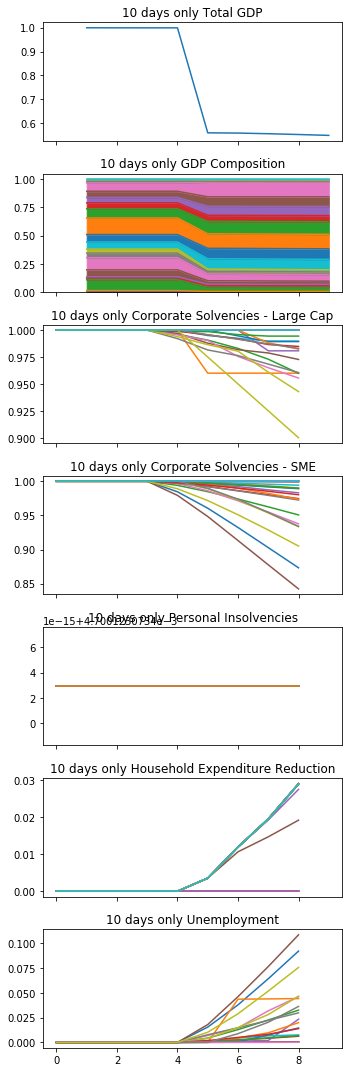

In [10]:
result = simulator.simulate_multi(scenarios, show_plots=True, figsize=(5, 15))

Metrics

In [11]:
econ, states = result['10 days only']

In [12]:
from adapter_covid19.metrics import get_quarterly_gdp_decline, get_quarterly_demand_decline

In [13]:
starting_date = pd.Timestamp('2020-03-28').date()

In [14]:
get_quarterly_gdp_decline(starting_date, states)

,GDP decline simulation,GDP decline estimates
2020-03-31,0.999242,0.97
2020-06-30,0.548113,0.75
2020-09-30,NaN,NaN
2020-12-31,NaN,0.86


In [15]:
get_quarterly_demand_decline(starting_date, econ, states)

,Demand decline simulation,Demand decline estimates
2020-03-31,1.000000,0.70
2020-06-30,0.971373,0.55


In [17]:
from adapter_covid19.enums import EmploymentState, Region, Sector, Age

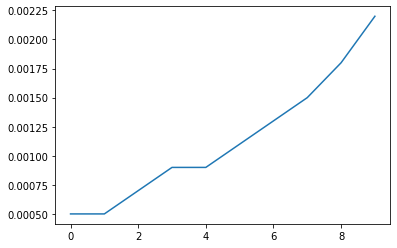

In [19]:
plt.plot([state.ill[(EmploymentState.WFO, Region.C_NE, Sector.A_AGRICULTURE, Age.A18)] for state in states])